# ARIMA

**ARIMA (Auto Regressive Integrated Moving Average)**
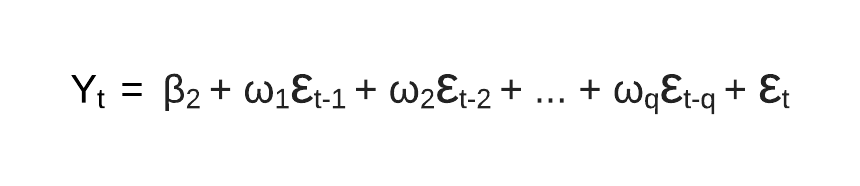

Auto Regressive - AR(p): Number of autoregressive lags

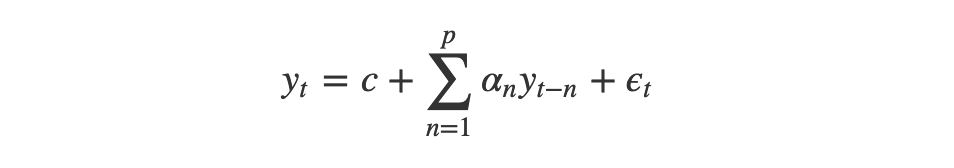
Note: AR(0): White noise

Moving Average - MA(q): Moving average model with q number of lagged forecasting error terms in prediction

Order of differencing - d: Number of times differencing pre-processing step is applied to make the time series stationary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy import stats
from scipy.stats import normaltest

from sklearn.metrics import mean_squared_error

from IPython.display import clear_output
import warnings

In [2]:
train_df = pd.read_csv("../train.csv")
train_df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [3]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [4]:
# split data in train and test
train = train_df.loc[train_df['date'] < '2017-10-01' ]
test = train_df.loc[train_df['date'] >= '2017-10-01' ] # use last 3 months as test data

In [5]:
train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912903,2017-09-26,10,50,79
912904,2017-09-27,10,50,80
912905,2017-09-28,10,50,82
912906,2017-09-29,10,50,90


In [6]:
test

,date,store,item,sales
1734,2017-10-01,1,1,21
1735,2017-10-02,1,1,12
1736,2017-10-03,1,1,18
1737,2017-10-04,1,1,15
1738,2017-10-05,1,1,20
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [7]:
def get_sales(train, test, store, item):
  result = []
  for data in [train, test]:
    sales = data.loc[data['store'] == int(store)].loc[data['item'] == int(item)]
    dates = sales['date'].dt.strftime('%Y-%m-%d')
    sales = sales['sales'].tolist()
    result += [sales, dates]
              
  return result

In [8]:
# https://machinelearningmastery.com/time-series-seasonality-with-python/

# Removing Seasonality
def remove_seasonality(data, days_in_year=365):
    diff = []
    for i in range(days_in_year, len(data)):
        value = data[i] - data[i - days_in_year]
        diff.append(value)
    return np.array(diff)

# Reconstruct seasonal component
def construct_seasonality(history, yhat, interval=365):
    return yhat + history[-interval]

In [9]:
def evaluate_arima(train, test, arima_order):   
    history = [x for x in train]   
    predictions = []
    
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()          
        yhat = model_fit.forecast()[0]         
        predictions.append(yhat)
        history.append(test[t])
        
    return mean_squared_error(test, predictions)

In [10]:
store, item = 2, 3

train_item, dates_train, test_item, dates_test = get_sales(train, test, store, item)
removed = remove_seasonality(train_item, 365)

# Fit Model (Abritrary order)
model = ARIMA(removed, order=(7, 0, 1))
model_fit = model.fit()

# Prediction - one step
forecast = model_fit.forecast()[0]
forecast = construct_seasonality(train_item, forecast, 365)
start, end = len(removed), len(removed)
prediction = model_fit.predict(start, end)
prediction = construct_seasonality(train_item, prediction, 365)

# Prediction - mutiple step
forecast = model_fit.forecast(steps=7)

history = [x for x in train_item]
day = 1
for yhat in forecast:
    inverted = construct_seasonality(history, yhat, 365)
    history.append(inverted)
    day +=1
start = len(removed)
end = start + day-1
prediction = model_fit.predict(start, end)

history_pred = [x for x in train_item]
day = 1
for yhat in prediction:
    inverted = construct_seasonality(history_pred, yhat, 365)
    history_pred.append(inverted)
    day +=1

In [11]:
# finding the best parameters
def grid_search(train, test, p_values, d_values, q_values):
    train = np.array(train).astype('float32')
    test = np.array(test).astype('float32')
    
    best_score, best_config = float('inf'), None
    
    for p in p_values:
        for d in d_values:            
            for q in q_values:
                order = (p,d,q)
                
                mse = evaluate_arima(train, test, order)
                if mse < best_score:
                    best_score, best_config = mse, order                 
                print('ARIMA%s MSE=%.3f' % (order, mse))
    
    return best_config

In [12]:
p_values = [6, 7, 8] # lag values
d_values = [1] # difference iterations
q_values = [0, 2, 3, 4] #residual error lag values

warnings.filterwarnings("ignore")
arima_order = grid_search(train_item, test_item, p_values, d_values, q_values)

ARIMA(6, 1, 0) MSE=93.506
ARIMA(6, 1, 2) MSE=92.450
ARIMA(6, 1, 3) MSE=90.752
ARIMA(6, 1, 4) MSE=89.842
ARIMA(7, 1, 0) MSE=93.841
ARIMA(7, 1, 2) MSE=92.707
ARIMA(7, 1, 3) MSE=93.046
ARIMA(7, 1, 4) MSE=92.946
ARIMA(8, 1, 0) MSE=92.601
ARIMA(8, 1, 2) MSE=95.175
ARIMA(8, 1, 3) MSE=93.363
ARIMA(8, 1, 4) MSE=92.253


In [13]:
# Forecasting with best model parameters
def predict_arima(arima_order, train_item, dates_train, test_item, dates_test):
    days = 90
    
    removed = remove_seasonality(train_item, 365)

    model = ARIMA(removed, order=arima_order)
    model_fit = model.fit(disp=0)

    forecast = model_fit.forecast(steps=days)
    history = [x for x in train_item]
    day = 1
    for yhat in forecast:
        inverted = construct_seasonality(history, yhat, 365)
        history.append(inverted)
        day +=1
    
    return history

In [14]:
def predict_all_arima(data, arima_order):
    cols = ["date", "store", "item", "sales"]
    df_out = pd.DataFrame()
    
    stores = list(np.arange(1, 11))
    items = list(np.arange(1, 51))

    for store in stores:
        data_store = data.loc[data['store'] == store]
        
        for item in items:
            predictions = []
            clear_output(wait=True)
            print('Processing store ' + str(store) + '/10 and item ' + str(item) + '/50')
            
            data_store_item = data_store.loc[data_store['item'] == item]
         
            train = data_store_item.loc[data_store_item['date'] < '2017-10-01' ]
            test = data_store_item.loc[data_store_item['date'] >= '2017-10-01' ]
            
            train_store_item, dates_train, test_store_item, dates_test = get_sales(train, test, store, item)
            
            days = len(test_store_item)
            
            removed = remove_seasonality(train_store_item, 365)
            model = ARIMA(removed, order=arima_order)
            model_fit = model.fit()

            forecast = model_fit.forecast(steps=days)
            
            history = [x for x in train_store_item]
            day = 1
            for yhat in forecast:
                inverted = construct_seasonality(history, yhat, 365)
                predictions.append(inverted)
                day +=1
            
            test["ARIMA"] = predictions           
            df_out = df_out.append(test, ignore_index=True)
    
    df_out.to_csv("ARIMA_results.csv")
    return df_out

df = train_df
df['date'] = pd.to_datetime(df['date'])
df_arima = predict_all_arima(df, arima_order)

Processing store 10/10 and item 50/50


In [15]:
df_test = pd.read_csv('../test.csv', parse_dates=['date'], index_col=['date'])
df_test

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1
...,...,...,...
2018-03-27,44995,10,50
2018-03-28,44996,10,50
2018-03-29,44997,10,50


In [16]:
arima_results = df_test
arima_results['sales'] = 0
arima_results

,id,store,item,sales
date,,,,
2018-01-01,0,1,1,0
2018-01-02,1,1,1,0
2018-01-03,2,1,1,0
2018-01-04,3,1,1,0
2018-01-05,4,1,1,0
...,...,...,...,...
2018-03-27,44995,10,50,0
2018-03-28,44996,10,50,0
2018-03-29,44997,10,50,0


In [17]:
df_train = pd.read_csv('../train.csv', parse_dates=['date'], index_col=['date'])
df_train

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


In [18]:
for s in arima_results['store'].unique():
    for i in arima_results['item'].unique():
        si = df_train.loc[(df_train['store'] == s) & (df_train['item'] == i), 'sales']
        
        arima_model = ARIMA(si, order=arima_order)
        results = arima_model.fit()
        
        fcst = results.predict(start='2017-12-31', end='2018-03-31', dynamic=True)
        arima_results.loc[(arima_results['store'] == s) & (arima_results['item'] == i), 'sales'] = fcst.values[1:]
        
        if i % 10 == 0:
            print("Completed store {} item {}.".format(s, i))

Completed store 1 item 10.
Completed store 1 item 20.
Completed store 1 item 30.
Completed store 1 item 40.
Completed store 1 item 50.
Completed store 2 item 10.
Completed store 2 item 20.
Completed store 2 item 30.
Completed store 2 item 40.
Completed store 2 item 50.
Completed store 3 item 10.
Completed store 3 item 20.
Completed store 3 item 30.
Completed store 3 item 40.
Completed store 3 item 50.
Completed store 4 item 10.
Completed store 4 item 20.
Completed store 4 item 30.
Completed store 4 item 40.
Completed store 4 item 50.
Completed store 5 item 10.
Completed store 5 item 20.
Completed store 5 item 30.
Completed store 5 item 40.
Completed store 5 item 50.
Completed store 6 item 10.
Completed store 6 item 20.
Completed store 6 item 30.
Completed store 6 item 40.
Completed store 6 item 50.
Completed store 7 item 10.
Completed store 7 item 20.
Completed store 7 item 30.
Completed store 7 item 40.
Completed store 7 item 50.
Completed store 8 item 10.
Completed store 8 item 20.
C

In [19]:
submission = arima_results[['id', 'sales']]
submission.to_csv("submission.csv", index=False)